# 1. Correlation between Precipitaion and Elevation for New jersey in year 2016

Summary:

The project is about correlating precipitation with elevations across different places in New Jersey. For this, I have three different file formats used .csv, .tif(DEM) and .nc4(Precipitation). Using the lat,lon coordinates in .csv file the data of elevation and precipitation is extracted from the .tif and .nc4 file. Then the datas are merged and the correlation is plotted.


## 1. Data Collection

### 1.1 Download daily precipitation data from NASA for year 2016

Downloaded GPM Daily Precipitaion data from "https://measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/" 
 
  Code used in terminal
- echo "machine urs.earthdata.nasa.gov login danraj567 password ***************" > ~/.netrc
- chmod 0600 ~/.netrc

In [188]:
! wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies -r -np -A ".nc4" -P / https://measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/

--2023-12-04 16:37:02--  https://measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/
Resolving measures.gesdisc.eosdis.nasa.gov (measures.gesdisc.eosdis.nasa.gov)... 198.118.197.57, 2001:4d0:241a:4041::57
Connecting to measures.gesdisc.eosdis.nasa.gov (measures.gesdisc.eosdis.nasa.gov)|198.118.197.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Precipdata/measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/index.html’

    [ <=>                                   ] 200,831     --.-K/s   in 0.02s   

2023-12-04 16:37:02 (7.69 MB/s) - ‘Precipdata/measures.gesdisc.eosdis.nasa.gov/data/GPCP/GPCPDAY.3.1/2016/index.html’ saved [200831]

Loading robots.txt; please ignore errors.
--2023-12-04 16:37:02--  https://measures.gesdisc.eosdis.nasa.gov/robots.txt
Connecting to measures.gesdisc.eosdis.nasa.gov (measures.gesdisc.eosdis.nasa.gov)|198.118.197.57|:443... connected.
HTTP request sent, awaiting response... 200 O

### 1.2 DEM file USA

The DEM file is which I had previously from my research. You can download it from different sites as it is free. But the reproducer needs to be sure it covers the New Jersey area.

In [157]:
! wget https://github.com/HyDROSLab/EF5-US-Parameters/raw/master/basic/dem_usa.tif

--2023-12-04 16:28:31--  https://github.com/HyDROSLab/EF5-US-Parameters/raw/master/basic/dem_usa.tif
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HyDROSLab/EF5-US-Parameters/master/basic/dem_usa.tif [following]
--2023-12-04 16:28:31--  https://raw.githubusercontent.com/HyDROSLab/EF5-US-Parameters/master/basic/dem_usa.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40253251 (38M) [application/octet-stream]
Saving to: ‘dem_usa.tif’

100%[======================================>] 40,253,251  28.3MB/s   in 1.4s   

2023-12-04 16:28:33 (28.3 MB/s) - ‘dem_usa.tif’ saved [40253251/40253251]



### 1.3 Cities in New Jersey

The locations were taken from the "https://simplemaps.com/data/us-cities". 

In [158]:
! wget https://simplemaps.com/static/data/us-cities/1.77/basic/simplemaps_uscities_basicv1.77.zip

--2023-12-04 16:28:51--  https://simplemaps.com/static/data/us-cities/1.77/basic/simplemaps_uscities_basicv1.77.zip
Resolving simplemaps.com (simplemaps.com)... 104.26.12.95, 104.26.13.95, 172.67.71.113, ...
Connecting to simplemaps.com (simplemaps.com)|104.26.12.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4220590 (4.0M) [application/zip]
Saving to: ‘simplemaps_uscities_basicv1.77.zip’

100%[======================================>] 4,220,590   25.0MB/s   in 0.2s   

2023-12-04 16:28:51 (25.0 MB/s) - ‘simplemaps_uscities_basicv1.77.zip’ saved [4220590/4220590]



## 1.4 Importing required libraries

In [159]:
#Other libraries are imported when needed!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import seaborn as sns
from scipy.stats import linregress
import xarray as xr 
from rasterio.plot import show
from rasterio.enums import Resampling
import os
import zipfile

## 2.1 Extracting the coordinates of NJ from file.

# 2. Reading the Files

## 2.1 Reading cities location CSV file

In [160]:
with zipfile.ZipFile('simplemaps_uscities_basicv1.77.zip', 'r') as zip_ref: #Extracting the zip file.
    zip_ref.extractall()

In [161]:
# Read the CSV file
df = pd.read_csv('uscities.csv')
df.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18908608,11226.2,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,11922389,3202.3,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8497759,4648.7,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6080145,4728.2,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Houston,Houston,TX,Texas,48201,Harris,29.7860,-95.3885,5970127,1382.2,shape,False,True,America/Chicago,1,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925


In [162]:
# Filter for cities in New Jersey (NJ)
nj_cities = df[df['state_id'] == 'NJ']
print("Cities in New Jersey:")
nj_cities=nj_cities.head(20)
nj_cities.head()

Cities in New Jersey:


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
118,Trenton,Trenton,NJ,New Jersey,34021,Mercer,40.2237,-74.7641,362179,4573.4,shape,False,True,America/New_York,2,08638 08611 08618 08629 08609 08608 08601 0860...,1840001383
141,Newark,Newark,NJ,New Jersey,34013,Essex,40.7245,-74.1725,306247,4897.5,shape,False,True,America/New_York,2,07103 07102 07105 07104 07107 07106 07108 0711...,1840002791
151,Jersey City,Jersey City,NJ,New Jersey,34017,Hudson,40.7184,-74.0686,287146,7517.5,shape,False,True,America/New_York,2,07310 07311 07302 07307 07306 07305 07304 0709...,1840003600
281,Paterson,Paterson,NJ,New Jersey,34031,Passaic,40.9147,-74.1624,157927,7247.6,shape,False,True,America/New_York,2,07522 07524 07514 07513 07505 07501 07504 0750...,1840000838
331,Elizabeth,Elizabeth,NJ,New Jersey,34039,Union,40.6658,-74.1913,135772,4255.4,shape,False,True,America/New_York,2,07208 07202 07201 07206 07207,1840003613


## 2.2 Reading NetCDF file

In [163]:

# Directory containing the NetCDF files 
nc_directory = 'Precipitation_data/' #The file is generally saved in another folder I manually placed it in this folder.
 # Here we need os beacuse we are interacting with the folders
nc_files = [os.path.join(nc_directory, f) for f in os.listdir(nc_directory) if f.endswith('.nc4')] #looping to get all netcdf files
ds = xr.open_mfdataset(nc_files, combine='by_coords') #the netcdf files are combined with coordinates because I would be using the coordinates to call the datas
print(ds) 

<xarray.Dataset>
Dimensions:                    (lon: 720, lat: 360, time: 366, bnds: 2)
Coordinates:
  * lon                        (lon) float32 -179.8 -179.2 ... 179.2 179.8
  * lat                        (lat) float32 89.75 89.25 88.75 ... -89.25 -89.75
  * time                       (time) datetime64[ns] 2016-01-01 ... 2016-12-31
Dimensions without coordinates: bnds
Data variables:
    precip                     (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    probability_liquid_precip  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    time_bnds                  (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/67)
    ShortName:                      GPCPDAY
    LongName:                       GPCP Precipitation Level 3 Daily 0.5-Degr...
    VersionID:                      3.1
    GranuleID:                      GPCPDAY_L3_20160101_V3.1.nc4
    Format:                         N

Data Interpretation: The data are of 0.5 degrees resolution which means around 7-8 tiles is enough to get data in Jersey. 

In [164]:
ds.variables

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 720)>
array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75],
      dtype=float32)
Attributes:
    long_name:    Longitude
    units:        degrees_east
    description:  Center longitude, 'lat': <xarray.IndexVariable 'lat' (lat: 360)>
array([ 89.75,  89.25,  88.75, ..., -88.75, -89.25, -89.75], dtype=float32)
Attributes:
    long_name:    Latitude
    units:        degrees_north
    description:  Center latitude, 'time': <xarray.IndexVariable 'time' (time: 366)>
array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', ..., '2016-12-29T00:00:00.000000000',
       '2016-12-30T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:       Time
    description:     Observation Time
    time_increment:  one day
    begin_date:      20160101
    begin_time:      000000
    end_date:        20160101
    end_time:        23

## 2.3 Reading the DEM file

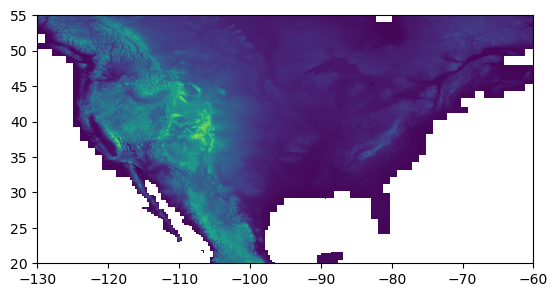

<Axes: >

In [165]:
dem = rio.open('dem_usa.tif') #Reading the DEM file
show(dem)

In [166]:
dem.meta 

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 7000,
 'height': 3500,
 'count': 1,
 'crs': CRS.from_epsg(4269),
 'transform': Affine(0.009999999999999998, 0.0, -130.0,
        0.0, -0.009999999999999998, 55.0)}

## 3. Process

### 3.1 Reading the elevation from DEM from the lat and lng of cities

In [167]:
elevations = []
for index, row in nj_cities.iterrows(): # Creating loop for getting dem data from coordinates of nj_cities to dem file
    lon, lat = row['lng'], row['lat']
    row_idx, col_idx = dem.index(lon, lat)
    if row_idx < dem.height and col_idx < dem.width:
        elevation = dem.read(1)[row_idx, col_idx]
        elevations.append(elevation)

In [168]:
elevations

[20.00121,
 23.1798,
 20.25489,
 28.67408,
 7.126778,
 43.69187,
 30.21235,
 5.761,
 10.40905,
 33.26028,
 55.89707,
 60.67026,
 1.687291,
 21.36265,
 34.60588,
 31.25146,
 50.46162,
 54.26401,
 12.09991,
 18.96558]

In [169]:
nj_cities['elevation'] = elevations
nj_cities.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id,elevation
118,Trenton,Trenton,NJ,New Jersey,34021,Mercer,40.2237,-74.7641,362179,4573.4,shape,False,True,America/New_York,2,08638 08611 08618 08629 08609 08608 08601 0860...,1840001383,20.001209
141,Newark,Newark,NJ,New Jersey,34013,Essex,40.7245,-74.1725,306247,4897.5,shape,False,True,America/New_York,2,07103 07102 07105 07104 07107 07106 07108 0711...,1840002791,23.179800
151,Jersey City,Jersey City,NJ,New Jersey,34017,Hudson,40.7184,-74.0686,287146,7517.5,shape,False,True,America/New_York,2,07310 07311 07302 07307 07306 07305 07304 0709...,1840003600,20.254890
281,Paterson,Paterson,NJ,New Jersey,34031,Passaic,40.9147,-74.1624,157927,7247.6,shape,False,True,America/New_York,2,07522 07524 07514 07513 07505 07501 07504 0750...,1840000838,28.674080
331,Elizabeth,Elizabeth,NJ,New Jersey,34039,Union,40.6658,-74.1913,135772,4255.4,shape,False,True,America/New_York,2,07208 07202 07201 07206 07207,1840003613,7.126778


In [170]:
nj_cities = pd.DataFrame(zip(nj_cities['city'], nj_cities['lat'], nj_cities['lng'], nj_cities['elevation']),columns=['city', 'lat', 'lng', 'elevation'])

There are unnecessary datas that I don't require. Just filtering out what I want.

In [171]:
nj_cities

,city,lat,lng,elevation
0,Trenton,40.2237,-74.7641,20.001209
1,Newark,40.7245,-74.1725,23.179800
2,Jersey City,40.7184,-74.0686,20.254890
3,Paterson,40.9147,-74.1624,28.674080
4,Elizabeth,40.6658,-74.1913,7.126778
5,Clifton,40.8630,-74.1575,43.691872
6,Vineland,39.4653,-74.9981,30.212351
7,Camden,39.9361,-75.1073,5.761000
8,Bayonne,40.6668,-74.1158,10.409050
9,Passaic,40.8574,-74.1282,33.260281


In [172]:
# Export the DataFrame to a CSV file
nj_cities.to_csv('nj_cities_elevation20.csv', index=False)

An alternative approach for this using Xarray. Running on my PC didn't have any problems but in amarel it raised valueerror.
ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

## 3.2 Reading the datas from the NetCDF file for  'lat', 'lng'

In [173]:
# Function to get precipitation for a given lat, lon
def get_precip(lat, lon, ds):
    # Find the nearest point 
    precip = ds.sel(lat=lat, lon=lon, method='nearest')['precip']
    return precip



In [174]:
# Dictionary to store accumulated monthly precipitation data
precip = {}

# Loop through each city
for index, row in nj_cities.iterrows():
    city_name = row['city']
    lat, lon = row['lat'], row['lng']
    
    # Extract precipitation data
    precip_data = get_precip(lat, lon, ds)
    
    # Convert to DataFrame
    precip_df = precip_data.to_dataframe().reset_index()
    
    # Resample to get monthly data and sum the precipitation
    monthly_precip = precip_df.resample('M', on='time')['precip'].sum()
    
    precip[city_name] = monthly_precip

In [175]:
city_precip_df = pd.DataFrame(precip).T
city_precip_df.head()

time,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31
Trenton,102.451118,127.356354,45.497688,53.928032,116.734886,61.555893,151.710983,52.231285,72.842445,69.060150,105.415062,79.444344
Newark,102.054184,126.608345,40.666119,52.440552,99.493729,52.370468,140.407761,51.193188,48.201614,64.955902,135.561554,82.921150
Jersey City,102.054184,126.608345,40.666119,52.440552,99.493729,52.370468,140.407761,51.193188,48.201614,64.955902,135.561554,82.921150
Paterson,102.054184,126.608345,40.666119,52.440552,99.493729,52.370468,140.407761,51.193188,48.201614,64.955902,135.561554,82.921150
Elizabeth,102.054184,126.608345,40.666119,52.440552,99.493729,52.370468,140.407761,51.193188,48.201614,64.955902,135.561554,82.921150


In [176]:
# Export the DataFrame to a CSV file
city_precip_df.to_csv('city_monthly_mean_precipitation3.csv', index=False)


## 4. Cleansing Data
Just working on to rename the months, merging the datas.

In [177]:
precip=pd.read_csv('city_monthly_mean_precipitation3.csv')

In [178]:
ele=pd.read_csv('nj_cities_elevation20.csv')

In [179]:
precip.head()

,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31
0,102.451120,127.356350,45.49769,53.928032,116.734886,61.555893,151.71098,52.231285,72.842445,69.06015,105.41506,79.44434
1,102.054184,126.608345,40.66612,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.95590,135.56155,82.92115
2,102.054184,126.608345,40.66612,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.95590,135.56155,82.92115
3,102.054184,126.608345,40.66612,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.95590,135.56155,82.92115
4,102.054184,126.608345,40.66612,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.95590,135.56155,82.92115


In [180]:
merged_df = pd.concat([ele, precip], axis=1 ) #merging two CSV files

In [181]:
merged_df.columns

Index(['city', 'lat', 'lng', 'elevation', '2016-01-31', '2016-02-29',
       '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
       '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31'],
      dtype='object')

In [182]:
# Renaming the date columns to month names
date_column = {
    '2016-01-31': 'Jan',
    '2016-02-29': 'Feb',
    '2016-03-31': 'Mar',
    '2016-04-30': 'Apr',
    '2016-05-31': 'May',
    '2016-06-30': 'Jun',
    '2016-07-31': 'Jul',
    '2016-08-31': 'Aug',
    '2016-09-30': 'Sep',
    '2016-10-31': 'Oct',
    '2016-11-30': 'Nov',
    '2016-12-31': 'Dec'
}

merged_df.rename(columns=date_column, inplace=True)

In [183]:
merged_df

,city,lat,lng,elevation,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Trenton,40.2237,-74.7641,20.001209,102.451120,127.356350,45.497690,53.928032,116.734886,61.555893,151.71098,52.231285,72.842445,69.060150,105.415060,79.44434
1,Newark,40.7245,-74.1725,23.179800,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115
2,Jersey City,40.7184,-74.0686,20.254890,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115
3,Paterson,40.9147,-74.1624,28.674080,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115
4,Elizabeth,40.6658,-74.1913,7.126778,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115
5,Clifton,40.8630,-74.1575,43.691872,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115
6,Vineland,39.4653,-74.9981,30.212351,92.996070,124.064790,79.146610,79.448800,168.977800,72.230320,178.00833,54.825980,146.183500,90.636510,33.570553,94.37299
7,Camden,39.9361,-75.1073,5.761000,85.809070,124.640970,57.114730,61.707436,175.248320,80.724590,168.91348,60.890522,126.765340,61.659810,54.586130,80.05937
8,Bayonne,40.6668,-74.1158,10.409050,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115
9,Passaic,40.8574,-74.1282,33.260281,102.054184,126.608345,40.666120,52.440550,99.493730,52.370470,140.40776,51.193188,48.201614,64.955900,135.561550,82.92115


In [184]:
merged_df.to_csv('final_data_rev.csv',index=False)

# 5. Plotting Relations

Regression equation: y = -0.00x + 101.40
The correlation for Jan is -0.01 with p value 0.98
Regression equation: y = 0.00x + 126.19
The correlation for Feb is 0.08 with p value 0.73
Regression equation: y = 0.07x + 44.32
The correlation for Mar is 0.11 with p value 0.66
Regression equation: y = 0.05x + 53.87
The correlation for Apr is 0.12 with p value 0.61
Regression equation: y = -0.09x + 113.70
The correlation for May is -0.07 with p value 0.78
Regression equation: y = -0.08x + 58.41
The correlation for Jun is -0.18 with p value 0.46
Regression equation: y = 0.05x + 145.62
The correlation for Jul is 0.07 with p value 0.78
Regression equation: y = -0.04x + 52.51
The correlation for Aug is -0.26 with p value 0.27
Regression equation: y = -0.12x + 66.21
The correlation for Sep is -0.07 with p value 0.76
Regression equation: y = 0.08x + 66.70
The correlation for Oct is 0.16 with p value 0.49
Regression equation: y = 0.01x + 118.44
The correlation for Nov is 0.00 with p value 0.98
Regres

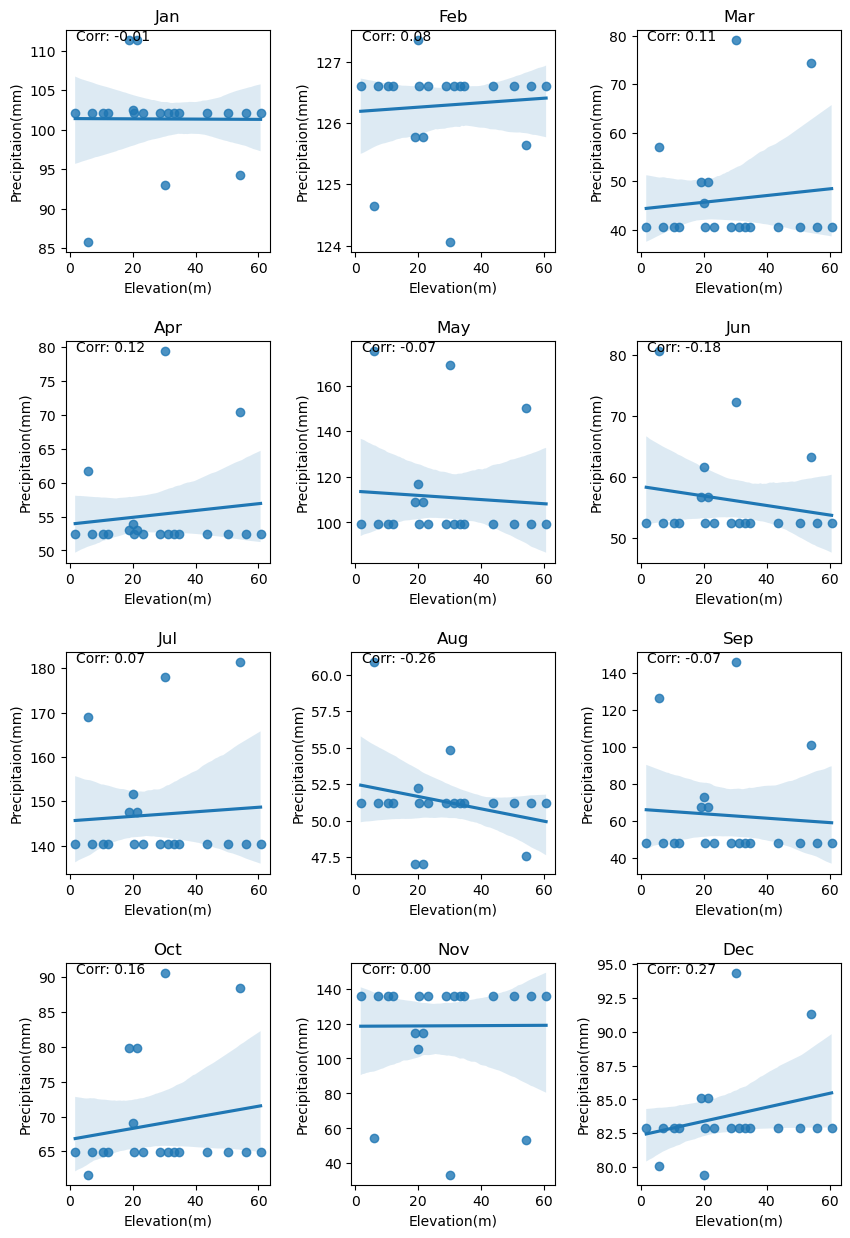

In [185]:

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15)) #Setting 
fig.subplots_adjust(hspace=0.4, wspace=0.4)
month_columns = merged_df.columns[4:] 
# Plotting each month's data in a subplot using seaborn
for i, month in enumerate(month_columns):
    ax = axes[i//3, i%3]
    sns.regplot(x='elevation', y=month, data=merged_df, ax=ax)
    ax.set_title(f'{month}')
    ax.set_xlabel('Elevation(m)')
    ax.set_ylabel('Precipitaion(mm)')

    # Calculate and display the correlation coefficients, linear regression equation,P value
    corr = np.corrcoef(merged_df['elevation'], merged_df[month])[0, 1]
    ax.text(0.05, 0.95, f'Corr: {corr:.2f}', transform=ax.transAxes) 
    
    x=merged_df['elevation']
    y=merged_df[month]
    slope, intercept, _, p, _ = linregress(x, y)
    print(f"Regression equation: y = {slope:.2f}x + {intercept:.2f}")
    print(f"The correlation for {month} is {corr:.2f} with p value {p:.2f}")     
plt.show()

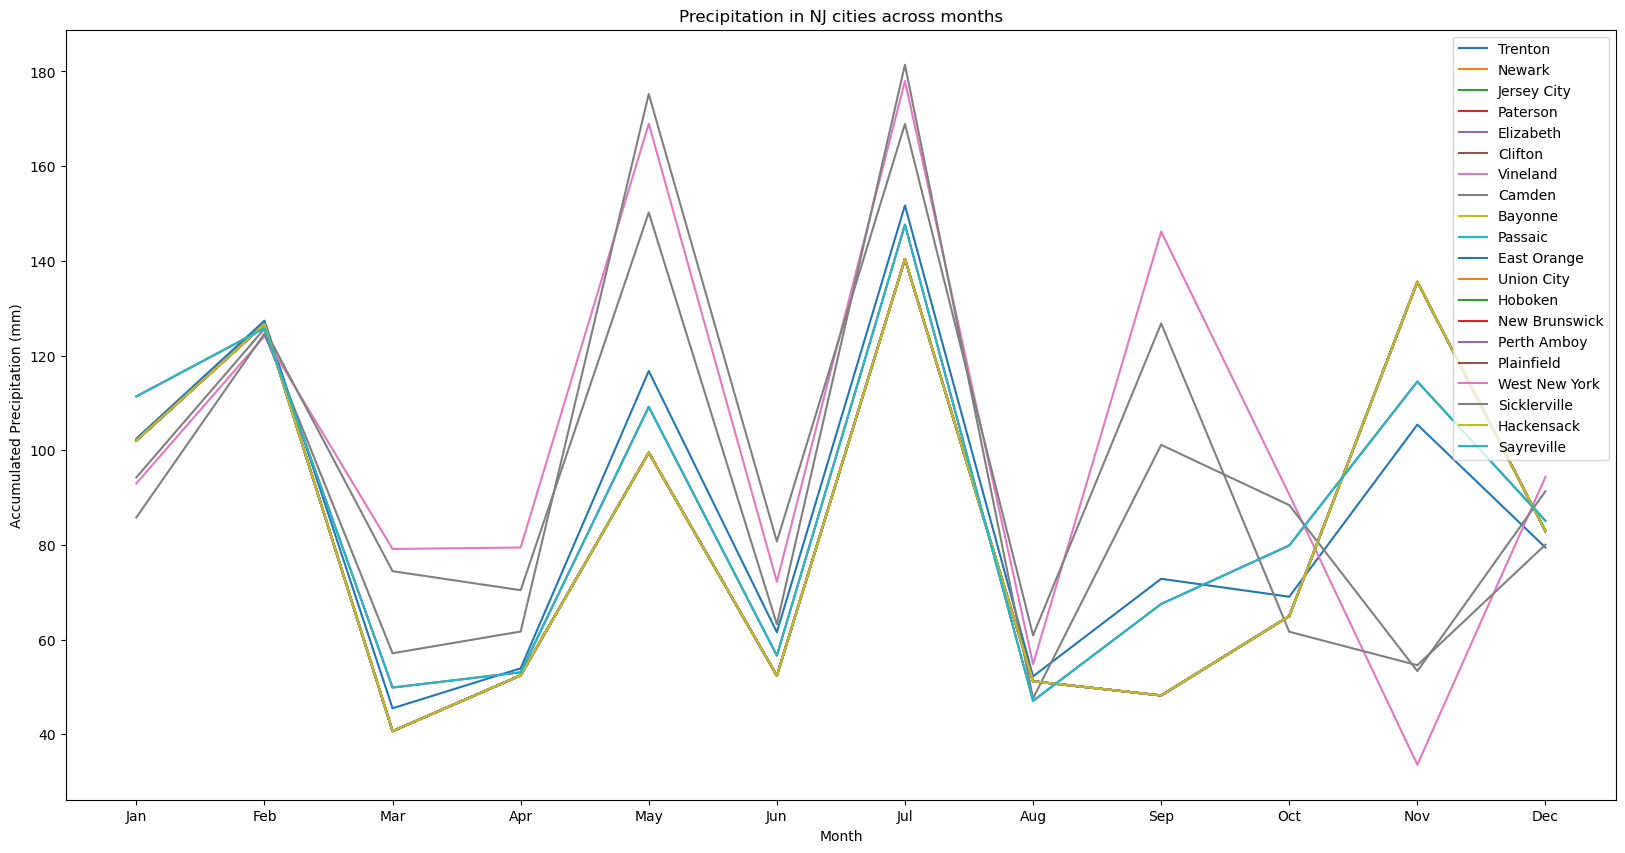

In [186]:
#plotting for different cities across months
month_columns = merged_df.columns[4:]
plt.figure(figsize=(20,10))
for i, city in enumerate(merged_df['city']):
    plt.plot(month_columns, merged_df.loc[i, month_columns], label=city)

# Adding plot details
plt.xlabel('Month')
plt.ylabel('Accumulated Precipitation (mm)')
plt.title('Precipitation in NJ cities across months')
plt.legend()

 
    

# 5. Conclusions
### Interpretation of the result:
The correlation coefficient is generally positive for elevations and precipitation but I believe the elevation which I am currently working doesn't have drastic difference ~60m. If you work on datas that provide a wide range of elevation difference then it would provide positive correlation. Another is the coarse dataset which I am using. 
